# Introduction

This notebook obtains tables and figures for the paper about edarop.

In [19]:
EDAROP_SOLS = "sols_edarop.p"
MALLOOVIA_SOL = "sols_malloovia.p"

# Case study inputs

## Reading

In [20]:
from pathlib import Path

import pickle
from typing import Tuple, List, Dict

import rich
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style("whitegrid")

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}' #for \text command

from edarop.edarop import Problem, Solution, SolvingStats, Status, Region
from edarop.visualization import ProblemPrettyPrinter
from edarop.analysis import SolutionAnalyzer

import use_case_edarop

In [21]:
system, workloads = use_case_edarop.set_up(None)

In [22]:
problem = Problem(system=system, workloads=workloads, max_cost=200)

In [23]:
pretty_problem = ProblemPrettyPrinter(problem) 
table_ics = pretty_problem.table_ics()
table_latencies = pretty_problem.table_latencies()
table_apps = pretty_problem.table_apps()

## Tables in Latex

In [24]:
def table_rich2latex(rich_table):
    header = " & ".join([c.header for c in rich_table.columns])
    latex_table =  [header + " \\\\"]

    for i in range(rich_table.row_count):
        latex_row = " & ".join([c._cells[i] for c in rich_table.columns])
        latex_table.append(latex_row + " \\\\")
        
    return latex_table

def print_latex_table(latex_table):
    for row in latex_table:
        print(row)

In [25]:
table_latex_ics = table_rich2latex(table_ics)

region_2_shortcut = {
    'eu-central-1': r'$\text{EU}_\text{c}$',
    'eu-central-1-ham-1a': r'$\text{EU}_\text{e}$',
    'eu-central-1-ham-1a-u': r'$\text{EU}_\text{u}$',
    'us-east-1': r'$\text{US-E}_\text{c}$',
    'us-east-1-atl-1a': r'$\text{US-E}_\text{e}$',
    'us-east-1-atl-1a-u': r'$\text{US-E}_\text{u}$',
    'us-west-2': r'$\text{US-W}_\text{c}$',
    'us-west-2-lax-1a': r'$\text{US-W}_\text{e}$',
    'us-west-2-lax-1a-u': r'$\text{US-W}_\text{u}$',
    'ap-south-1': r'$\text{AP}_\text{c}$',
    'ap-south-1-del-1a': r'$\text{AP}_\text{e}$',
    'ap-south-1-del-1a-u': r'$\text{AP}_\text{u}$',
}

# Extra information for the paper
table_latex_ics[0] = "\\toprule\n" + r"AWS region & Short name & Type & Instance class & Price \\"
for i, row in enumerate(table_latex_ics):
    if i == 0:
        continue  # Skip the header because it was fixed before
        
    fields = row.split("&")
    aws_name = fields[0].strip()
    if aws_name != "":
        short_name = region_2_shortcut[aws_name]
        if aws_name.endswith("-1a"):
            region_type = "Edge"
        else:
            region_type = "Cloud"
            
        aws_name = "\\midrule\n" + aws_name
    else:
        short_name = ""  # Don't repeat the short names
        region_type = ""  # Don't repeat the region type

    price = fields[2].replace(" per 1 h", "")
    ic_name = fields[1].split("-")[0]
    table_latex_ics[i] = aws_name + " & " + short_name + " & " + region_type + " & " + ic_name + " & " + price

table_latex_ics.append("\\bottomrule")
print_latex_table(table_latex_ics)

\toprule
AWS region & Short name & Type & Instance class & Price \\
\midrule
eu-central-1 & $\text{EU}_\text{c}$ & Cloud &  c5.2xlarge &  0.388 \\
 &  &  &  c5.4xlarge &  0.776 \\
\midrule
eu-central-1-ham-1a & $\text{EU}_\text{e}$ & Edge &  c5.2xlarge &  0.524 \\
\midrule
us-east-1 & $\text{US-E}_\text{c}$ & Cloud &  c5.2xlarge &  0.34 \\
 &  &  &  c5.4xlarge &  0.68 \\
\midrule
us-east-1-atl-1a & $\text{US-E}_\text{e}$ & Edge &  c5d.2xlarge &  0.48 \\
\midrule
us-west-2 & $\text{US-W}_\text{c}$ & Cloud &  c5.2xlarge &  0.34 \\
 &  &  &  c5.4xlarge &  0.68 \\
\midrule
us-west-2-lax-1a & $\text{US-W}_\text{e}$ & Edge &  c5.2xlarge &  0.408 \\
 &  &  &  c5.4xlarge &  0.816 \\
\midrule
ap-south-1 & $\text{AP}_\text{c}$ & Cloud &  c5.2xlarge &  0.34 \\
 &  &  &  c5.4xlarge &  0.68 \\
\midrule
ap-south-1-del-1a & $\text{AP}_\text{e}$ & Edge &  c5.2xlarge &  0.459 \\
\bottomrule


In [26]:
def table_rich2df(rich_table):
    data = {}
    for c in rich_table.columns:
        data[c.header] = c.cells

    df = pd.DataFrame.from_dict(data)
    first_col = df.columns[0]
    df.set_index(first_col, inplace=True, drop=True)
    return df

df_latencies = table_rich2df(table_latencies)

In [27]:
df_latencies.rename(columns=region_2_shortcut, index=region_2_shortcut, inplace=True)
reg_dst_order = [r"$\text{EU}_\text{e}$", r"$\text{US-E}_\text{e}$", r"$\text{US-W}_\text{e}$", r"$\text{AP}_\text{e}$",
                 r"$\text{EU}_\text{c}$", r"$\text{US-E}_\text{c}$", r"$\text{US-W}_\text{c}$", r"$\text{AP}_\text{c}$"]
reg_src_order = [r"$\text{EU}_\text{u}$", r"$\text{US-E}_\text{u}$", r"$\text{US-W}_\text{u}$", r"$\text{AP}_\text{u}$"]
df_latencies = df_latencies[reg_dst_order].reindex(reg_src_order[:4])

In [28]:
print(df_latencies.style.to_latex(hrules=True))

\begin{tabular}{lllllllll}
\toprule
 & $\text{EU}_\text{e}$ & $\text{US-E}_\text{e}$ & $\text{US-W}_\text{e}$ & $\text{AP}_\text{e}$ & $\text{EU}_\text{c}$ & $\text{US-E}_\text{c}$ & $\text{US-W}_\text{c}$ & $\text{AP}_\text{c}$ \\
src / dst &  &  &  &  &  &  &  &  \\
\midrule
$\text{EU}_\text{u}$ & 8.72 & - & - & - & 16.20 & 106.90 & 214.30 & 125.80 \\
$\text{US-E}_\text{u}$ & - & 1.10 & - & - & 105.80 & 15.10 & 66.20 & 203.30 \\
$\text{US-W}_\text{u}$ & - & - & 0.90 & - & 147.90 & 59.90 & 23.60 & 247.20 \\
$\text{AP}_\text{u}$ & - & - & - & 8.50 & 179.40 & 234.60 & 294.90 & 27.10 \\
\bottomrule
\end{tabular}



In [29]:
df_apps = table_rich2df(table_apps)
latex_apps = df_apps.style.to_latex(hrules=True)

# Clean-up for the paper

# Thousands separator
latex_apps = latex_apps.replace("_", ",")

# Shortcuts for regions
for r in region_2_shortcut:
    if "-u" in r:  # Only user regions have "-u" in the name
        latex_apps = latex_apps.replace(r, region_2_shortcut[r])
        
# Remove the " x 1 s" in response time
latex_apps = latex_apps.replace(" x 1 s", "")

# Add a little horizontal space to make the workload for each zone inside the total
latex_apps = latex_apps.replace("&  &   ", r"&  &   \hspace{0.4cm}")

print(latex_apps)

\begin{tabular}{lll}
\toprule
 & Max. resp. time. & Workload (12 time slots of 1 h) \\
Name &  &  \\
\midrule
a0 & 0.2 & total: 773,036,071 \\
 &  &   \hspace{0.4cm}$\text{EU}_\text{u}$: 130,123,249 \\
 &  &   \hspace{0.4cm}$\text{US-E}_\text{u}$: 233,543,665 \\
 &  &   \hspace{0.4cm}$\text{US-W}_\text{u}$: 185,256,362 \\
 &  &   \hspace{0.4cm}$\text{AP}_\text{u}$: 224,112,795 \\
a1 & 0.325 & total: 577,659,276 \\
 &  &   \hspace{0.4cm}$\text{EU}_\text{u}$: 148,319,581 \\
 &  &   \hspace{0.4cm}$\text{US-E}_\text{u}$: 158,355,336 \\
 &  &   \hspace{0.4cm}$\text{US-W}_\text{u}$: 116,082,585 \\
 &  &   \hspace{0.4cm}$\text{AP}_\text{u}$: 154,901,774 \\
a2 & 0.05 & total: 339,913,812 \\
 &  &   \hspace{0.4cm}$\text{EU}_\text{u}$: 118,585,235 \\
 &  &   \hspace{0.4cm}$\text{US-E}_\text{u}$: 72,850,756 \\
 &  &   \hspace{0.4cm}$\text{US-W}_\text{u}$: 71,255,405 \\
 &  &   \hspace{0.4cm}$\text{AP}_\text{u}$: 77,222,416 \\
\bottomrule
\end{tabular}



In [30]:
perf_summ = {}
for perf_key, perf_value in problem.system.perfs.items():
    app = perf_key[0].name
    ic = perf_key[1].name
    vm_type = ic.split("-")[0]
    perf_summ[(app, vm_type)] = [perf_value.value.value, perf_value.slo.value]
    
df_perf = pd.DataFrame(perf_summ).T
df_perf.rename(columns={0: "Requests per second", 1: "SLO (s)"}, inplace=True)
latex_perf = df_perf.style.to_latex(multirow_align="naive", hrules=True)
latex_perf = latex_perf.replace("000", "")  # Pandas inserts extra zeros
latex_perf = latex_perf.replace("00 ", " ")  # Pandas inserts extra zeros
print(latex_perf)

\begin{tabular}{llrr}
\toprule
 &  & Requests per second & SLO (s) \\
\midrule
a0 & c5.2xlarge & 461.125 & 0.025 \\
 & c5.4xlarge & 919.905 & 0.025 \\
 & c5d.2xlarge & 449.114 & 0.025 \\
a1 & c5.2xlarge & 76.796 & 0.0125 \\
 & c5.4xlarge & 153.005 & 0.0125 \\
 & c5d.2xlarge & 80.296 & 0.0125 \\
a2 & c5.2xlarge & 263.760 & 0.040 \\
 & c5.4xlarge & 556.680 & 0.040 \\
 & c5d.2xlarge & 275.090 & 0.040 \\
\bottomrule
\end{tabular}



## Figures

In [31]:
FIG_DIR = Path(".")
TRACE_FILE = "edge_1h.csv"
wdf = pd.read_csv(TRACE_FILE)


In [32]:
region_index_2_shortcut = {
    0: region_2_shortcut["eu-central-1-ham-1a-u"],
    1: region_2_shortcut["us-east-1-atl-1a-u"],
    2: region_2_shortcut["us-west-2-lax-1a-u"],
    3: region_2_shortcut["ap-south-1-del-1a-u"],
}
wdf.reg = wdf.reg.map(region_index_2_shortcut)
wdf.rename(columns={"reg": "Region"}, inplace=True)
wdf.app = pd.Categorical(wdf.app).codes
wdf.timestamp = pd.to_datetime(wdf.timestamp)
wdf["hour"] = wdf.timestamp.map(pd.Timestamp.timestamp) / 3600

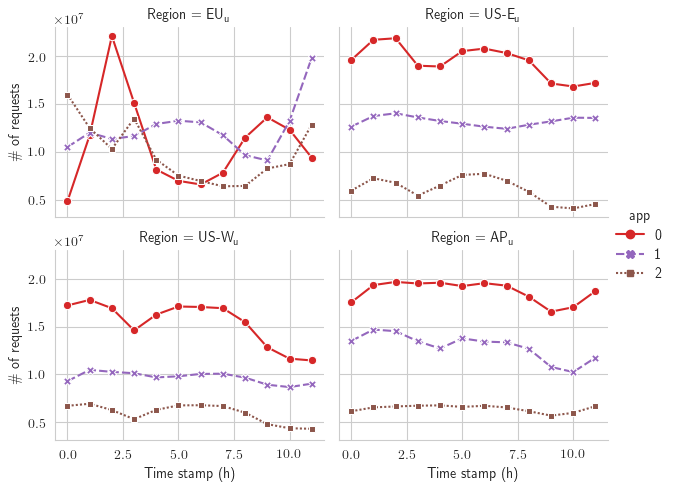

In [33]:
# Use the tab10 pallete but not from the first color to differenciate
# it from the colors of the tab20 pallete used for variants later
trace_palette = [plt.cm.tab10(i+3) for i in range(3)]
g = sns.relplot(data=wdf, x="hour", y="reqs",
           hue="app", style="app", col="Region", col_wrap=2,
           kind="line", markers=True, palette=trace_palette,
           height=2.5, aspect=1.25)
_ = g.set_axis_labels('Time stamp (h)', r'\# of requests')

In [34]:
g.fig.savefig(FIG_DIR/'traces.png', bbox_inches='tight', dpi=600)

# Results

In [35]:
all_sols = pickle.load(open(EDAROP_SOLS, "rb"))

## Cost and response time

In [36]:
def get_summary(sol: Solution):
    """Receives an edarop Solution and returns a dictionary with the cost,
    the average response time, the deadline miss rate and the stats."""
    analyzer = SolutionAnalyzer(sol)
    
    if sol.solving_stats.status in [Status.OPTIMAL, Status.INTEGER_FEASIBLE]:
        return {
            "cost": analyzer.cost(),
            "avg_resp_time": analyzer.avg_resp_time().value,
            "deadline_miss_rate": analyzer.deadline_miss_rate(),
            "total_reqs_per_app": analyzer.total_reqs_per_app(),
            "total_missed_reqs_per_app": analyzer.total_missed_reqs_per_app(),
            "stats": sol.solving_stats,
        }
    else:
        return {
            "cost": np.nan,
            "avg_resp_time": np.nan,
            "deadline_miss_rate": np.nan,
            "deadline_miss_rate": np.nan,
            "total_reqs_per_app": np.nan,
            "stats": sol.solving_stats
        }

In [37]:
def get_formatted_status(variant: str, summary) -> str:
    """Receives the name of a variant a summary of its execution in
    the form of a dict. Returns a string representing the status. It
    will be 'Optimal' if the status is optimal, or 'Feasible' with
    the bound and the gap."""
    stats = summary["stats"]
    if stats.status == Status.OPTIMAL:
        status = "Optimal"
    elif stats.status == Status.INTEGER_FEASIBLE:
        bound = summary['stats'].lower_bound
        if variant in ["EdaropC", "EdaropRC"]:
            base_sol = summary["cost"]
        elif variant in ["EdaropR", "EdaropCR"]:
            base_sol = summary["avg_resp_time"]
        else:
            raise ValueError()
                       
        gap = 100 * ((base_sol - bound) / bound)
        status = f"Feasible<br/>(bound: {bound}. gap: {gap:.2f}%)"
    else:
        status = str(stats.status.name)
    return status

In [38]:
variants = ["EdaropC", "EdaropCR", "EdaropR", "EdaropRC", "Greedy"]
costs = { i: [] for i in variants}
avg_resp_times = { i: [] for i in variants}
deadline_miss_rates = { i: [] for i in variants}
total_reqs_per_app = { i: [] for i in variants}
total_missed_reqs_per_app = { i: [] for i in variants}
statuses = { i: [] for i in variants}

for sols_ts in all_sols:
    for i, variant in enumerate(costs.keys()):
        summary = get_summary(sols_ts[i])
        costs[variant].append(summary["cost"])
        avg_resp_times[variant].append(summary["avg_resp_time"])
        deadline_miss_rates[variant].append(summary["deadline_miss_rate"])
        total_reqs_per_app[variant].append(summary["total_reqs_per_app"])
        total_missed_reqs_per_app[variant].append(summary["total_missed_reqs_per_app"])
        status = get_formatted_status(variant, summary)
        statuses[variant].append(status)

In [39]:
# Notice that this is the Malloovia solution transformed to Edarop
malloovia_sols = pickle.load(open(MALLOOVIA_SOL, "rb"))

In [40]:
variant = "Malloovia"
variants.append(variant)
costs[variant] = []
avg_resp_times[variant] = []
deadline_miss_rates[variant] = []
total_reqs_per_app[variant] = []
total_missed_reqs_per_app[variant] = []
statuses[variant] = []

for ts, sol in enumerate(malloovia_sols):
    sol = sol[0]  # For each time slot, there's an array with only the malloovia solution
    summary = get_summary(sol)
    costs[variant].append(summary["cost"])
    avg_resp_times[variant].append(summary["avg_resp_time"])
    deadline_miss_rates[variant].append(summary["deadline_miss_rate"])
    total_reqs_per_app[variant].append(summary["total_reqs_per_app"])
    total_missed_reqs_per_app[variant].append(summary["total_missed_reqs_per_app"])
    status = get_formatted_status(variant, summary)
    statuses[variant].append(status)
    
    # Add the malloovia solution to all sols
    all_sols[ts].append(sol)

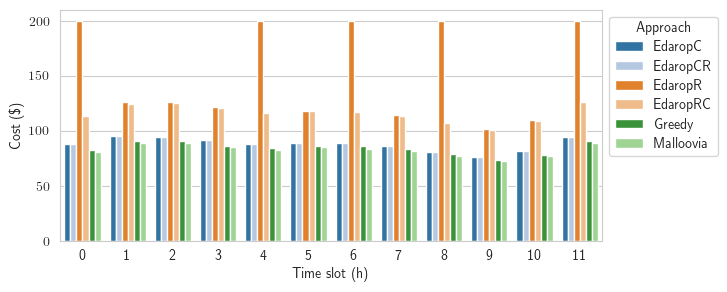

In [41]:
costs_df = pd.DataFrame(costs)
l_costs_df = costs_df.stack().reset_index().rename(columns={"level_0": "Time slot (h)", "level_1": "Approach", 0: r"Cost (\$)"})

plt.figure(figsize=(7,3))
g = sns.barplot(data=l_costs_df, x="Time slot (h)", y=r"Cost (\$)",
           hue="Approach",
           palette="tab20")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(FIG_DIR/'costs_ts.png', bbox_inches='tight', dpi=600)

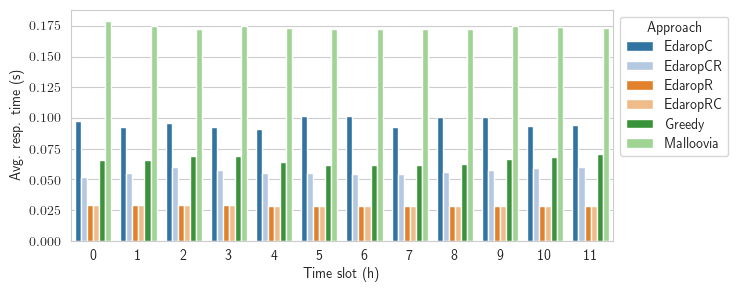

In [42]:
avg_resp_times_df = pd.DataFrame(avg_resp_times)
l_times_df = avg_resp_times_df.stack().reset_index().rename(columns={
    "level_0": "Time slot (h)", "level_1": "Approach", 0: "Avg. resp. time (s)"})

plt.figure(figsize=(7,3))
g = sns.barplot(data=l_times_df, x="Time slot (h)", y="Avg. resp. time (s)",
           hue="Approach",
           palette="tab20")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(FIG_DIR / 'tresp_ts.png', bbox_inches='tight', dpi=600)

## Cost vs response time

In [43]:
deadline_data = {}
for variant in total_reqs_per_app.keys():
    deadline_data[variant] = {"reqs": [0, 0, 0], # Each element will be the deadline miss for an application
                             "missed": [0, 0, 0]} 
    for ts_total_reqs, ts_missed_reqs in zip(total_reqs_per_app[variant], total_missed_reqs_per_app[variant]):
        for app_index, app in enumerate(ts_total_reqs.keys()):
            deadline_data[variant]["reqs"][app_index] += ts_total_reqs[app]
            deadline_data[variant]["missed"][app_index] += ts_missed_reqs[app]

agg_deadline_data = {}
for variant in deadline_data.keys():
    agg_deadline_data[variant] = []
    for reqs, missed in zip(deadline_data[variant]["reqs"], deadline_data[variant]["missed"]):
        miss_rate = 100 * missed / reqs
        agg_deadline_data[variant].append(miss_rate)
        
agg_deadline_data_df = pd.DataFrame(agg_deadline_data)
agg_deadline_data_df = agg_deadline_data_df.T.rename(columns={i:f"$a_{i}$" for i in range(3)})

In [44]:
# This is for the plot
df_cost_time = (pd.concat({r"Cost (\$)": costs_df.sum(),
                           "Avg. resp. time (s)": avg_resp_times_df.sum(),
                          },
                           axis=1)
                .reset_index()
                .rename(columns={"index": "Approach"})
               )

# This is for the table
df_cost_time_miss = (pd.concat({r"Cost ($)": costs_df.sum(),
                           "Avg. resp. time (s)": avg_resp_times_df.sum(),
                           r"Max. resp. time violation (\%)": agg_deadline_data_df,
                          },
                           axis=1)
                .reset_index()
                .rename(columns={"index": "Approach"})
               )

In [45]:
table_summary = df_cost_time_miss.style.hide(axis="index").to_latex(hrules=True)
table_summary = table_summary.replace("000 ", " ")\
                             .replace("($)", "(\$)")\
                             .replace("(%)", "(\%)")\
                             .replace("& 0 & 1", "& & ")
print(table_summary)

\begin{tabular}{lrrrrr}
\toprule
Approach & Cost (\$) & Avg. resp. time (s) & \multicolumn{3}{r}{Max. resp. time violation (\%)} \\
 & &  & $a_0$ & $a_1$ & $a_2$ \\
\midrule
EdaropC & 1050.500 & 1.155680 & 0.000 & 0.000 & 0.000 \\
EdaropCR & 1050.500 & 0.676842 & 0.000 & 0.000 & 0.000 \\
EdaropR & 1814.516 & 0.342884 & 0.000 & 0.000 & 0.000 \\
EdaropRC & 1387.876 & 0.342884 & 0.000 & 0.000 & 0.000 \\
Greedy & 1009.120 & 0.785741 & 0.000 & 0.000 & 100.000 \\
Malloovia & 990.420 & 2.089114 & 54.176001 & 0.000 & 100.000 \\
\bottomrule
\end{tabular}



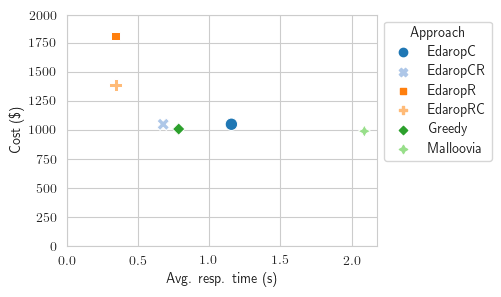

In [46]:
plt.figure(figsize=(4,3))
g = sns.scatterplot(data=df_cost_time, x="Avg. resp. time (s)", y=r"Cost (\$)",
               hue="Approach", style="Approach",
               s=80, palette="tab20")
g.set(ylim=(0, 2000))
g.set(xlim=(0))
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(FIG_DIR/'cost_vs_tresp.png', bbox_inches='tight', dpi=600)

## Schedule Edge vs Cloud

In [47]:
def is_edge_region(reg: Region) -> bool:
    """Returns true if the region is on the edge, which in this case
    is determined from the name: if it ends in '1-a', it's on the edge."""
    return reg.name.endswith("-1a")

def get_req_distribution(sol: Solution) -> List[Tuple[str, str, int]]:
    """Receives an edarop Solution and returns a list of values with this
    format:

        destination app requests
        
    Example:
    
        Edge app0 10
        Cloud app0 20
        Edge app1 7
        Cloud app1 14
    """
    alloc = sol.alloc

    req_apps = {a: {"Edge": 0, "Cloud": 0} for a in sol.problem.system.apps}
    
    for alloc_ts in alloc.time_slot_allocs:
        for key in alloc_ts.reqs:
            app = key[0]
            reg = key[1] 
            ic = key[2]
            ic_region = ic.region
            
            reqs = alloc_ts.reqs[key]
            
            if is_edge_region(ic_region):
                req_apps[app]["Edge"] += reqs
            else:
                req_apps[app]["Cloud"] += reqs
                
    res = []
    for app in req_apps.keys():
        for destination in ["Edge", "Cloud"]:
            res.append((destination, app.name, req_apps[app][destination]))
                
    return res

sched = []
for ts, sols_ts in enumerate(all_sols):
    sols = {}
    for i, variant in enumerate(variants):
        sol = sols_ts[i]
        for distribution in get_req_distribution(sol):
            sched.append((ts, variant, *distribution))

df_sched = pd.DataFrame(sched, columns=["Time slot (h)", "Approach", "Destination", "App", "Requests"])

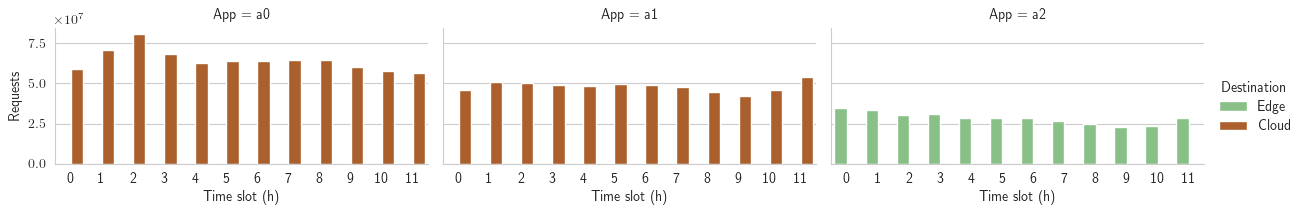

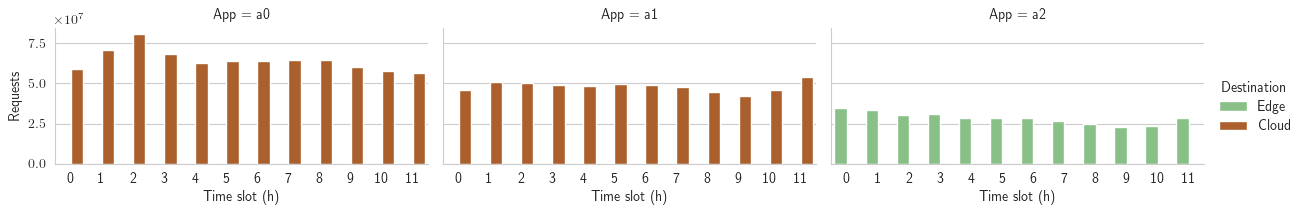

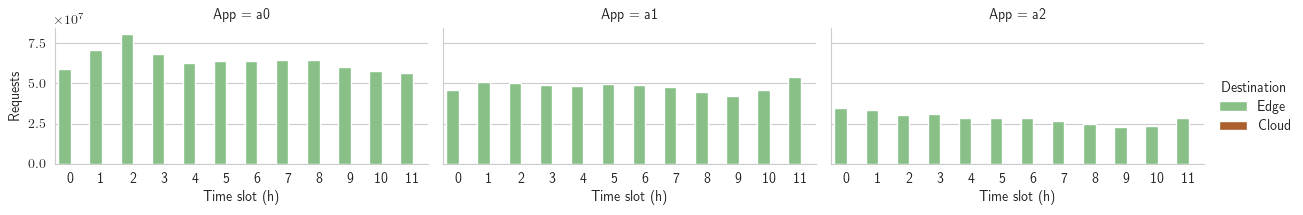

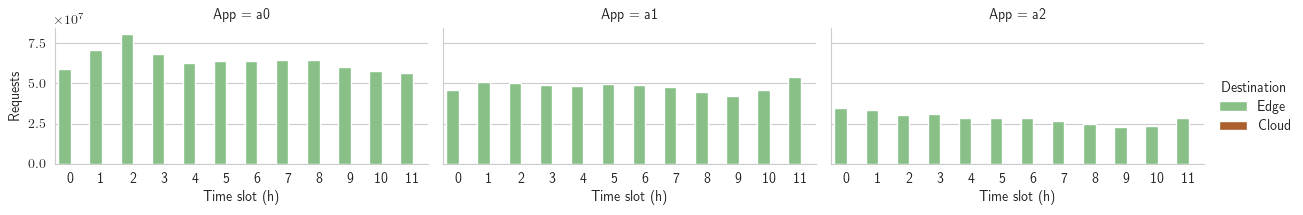

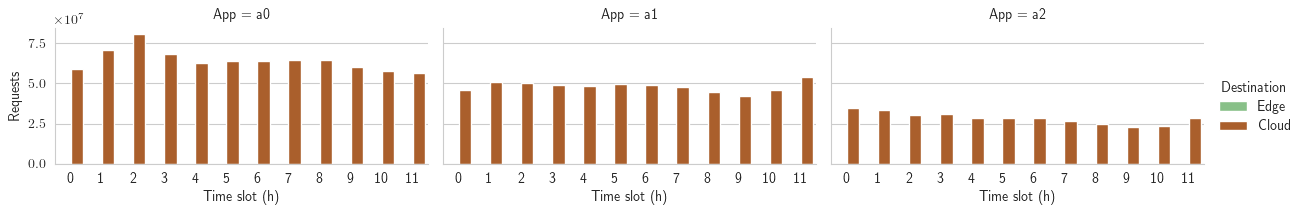

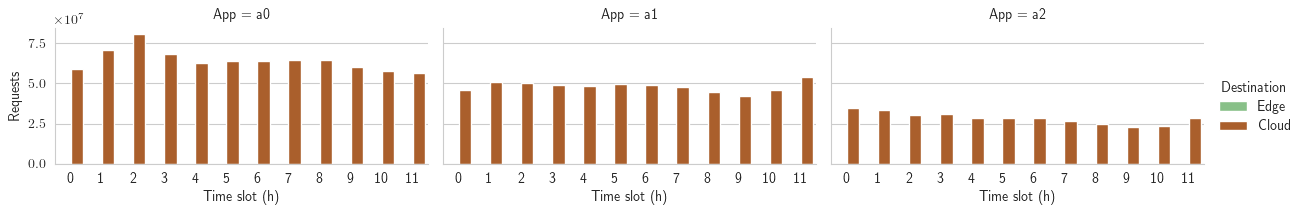

In [48]:
palette = [cm.Accent.colors[0], cm.Accent.colors[6]]
for approach in variants:
    # create a catplot of kind bar, but with the bars closer together
    g = sns.catplot(data=df_sched[df_sched.Approach==approach], x="Time slot (h)", y="Requests",
               hue="Destination", col="App", height=2.25, aspect=1.8,  kind="bar",
               palette=palette, errorbar=None, estimator=sum)
    plt.savefig(FIG_DIR/f'sched_{approach}.png', bbox_inches='tight', dpi=600)


### Using areas instead of bars

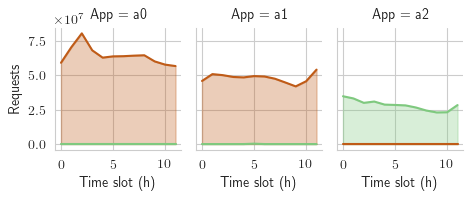

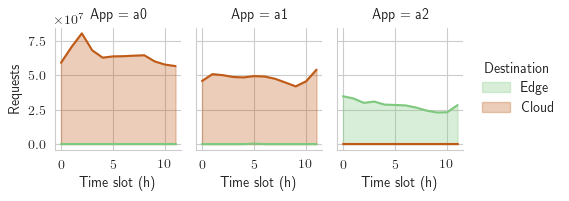

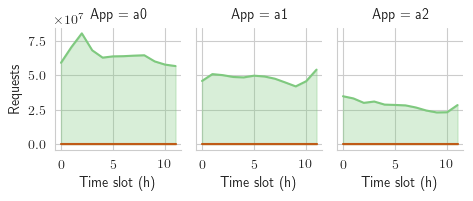

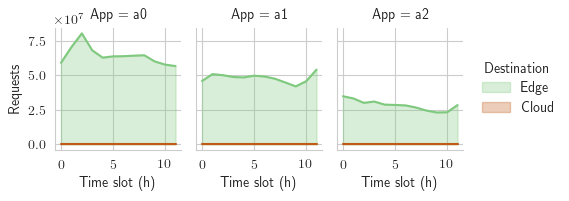

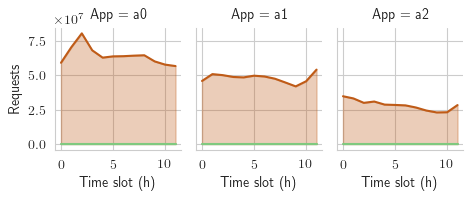

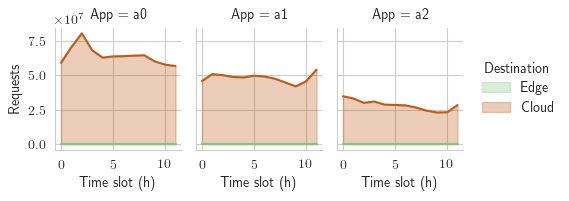

In [49]:
from matplotlib.patches import Patch

palette = [cm.Accent.colors[0], cm.Accent.colors[6]]
for i, approach in enumerate(variants):
    # create a catplot of kind bar, but with the bars closer together
    g = sns.FacetGrid(data=df_sched[df_sched.Approach==approach], 
                hue="Destination", col="App", height=2.25, aspect=0.7,
                palette=palette)#  errorbar=None, estimator=sum)
    def plot_area(*args, **kwargs):
        data = kwargs.pop("data")
        line = sns.lineplot(x="Time slot (h)", y="Requests", data=data, estimator="sum", **kwargs)
        # area_color = line.get_lines()[0].get_color()
        plt.fill_between(data["Time slot (h)"].unique(), data.groupby("Time slot (h)")["Requests"].sum(), alpha=0.3, **kwargs)
    g.map_dataframe(plot_area)

    if i%2:
        line_color0 = g.axes[0][0].lines[0].get_color()
        line_color1 = g.axes[0][0].lines[1].get_color()
        area_patch0 = Patch(facecolor=line_color0, alpha=0.3, label='Edge', edgecolor=line_color0)
        area_patch1 = Patch(facecolor=line_color1, alpha=0.3, label='Cloud', edgecolor=line_color1)
        plt.legend(handles=[area_patch0, area_patch1], bbox_to_anchor=(1.05, 0.5), 
                    loc='center left', title="Destination", frameon=False)
    plt.savefig(FIG_DIR/f'sched2_{approach}.png', bbox_inches='tight', dpi=600)

## Schedule - instances

In [50]:
def plot_alloc_dict(alloc_dict: Dict[str, int]): # key: ic name; value: num_vms
    df_allocs = pd.DataFrame(allocs)
    

def update_alloc_as_dict(sol: Solution, alloc_dict: Dict[str, int]): # key: ic name; value: num_vms
    """Receives a Solution with only one time slot and returns the allocation as
    a dictionary."""
    allocs = sol.alloc.time_slot_allocs
    assert len(allocs) == 1
    
    ics_alloc = allocs[0].ics
    
    for key, num_vms in ics_alloc.items():
        app = key[0]
        ic = key[1]
            
        if ic.name in alloc_dict:
            alloc_dict[ic.name] += int(num_vms)
        else:
            alloc_dict[ic.name] = int(num_vms)
    
allocs = []
for ts, sols_ts in enumerate(all_sols):
    for i, variant in enumerate(variants):
        sol = sols_ts[i]

        alloc_dict = { "ts": ts, "approach": variant}
        update_alloc_as_dict(sol, alloc_dict)
        allocs.append(alloc_dict)

df_allocs = pd.DataFrame(allocs)

# Remove columns with all zeros
df_allocs = df_allocs.loc[:, (df_allocs != 0).any(axis=0)]

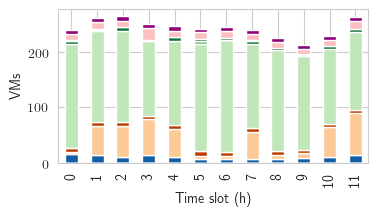

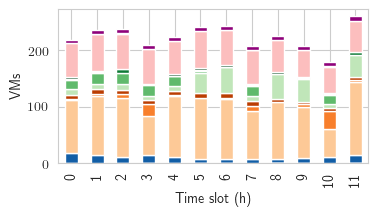

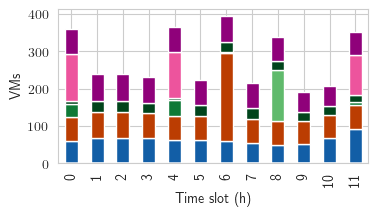

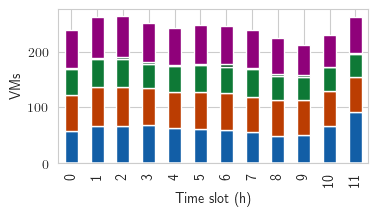

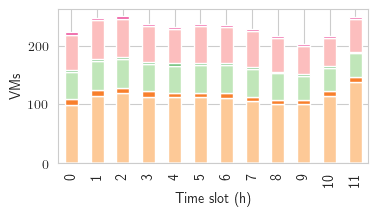

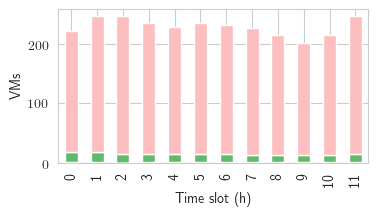

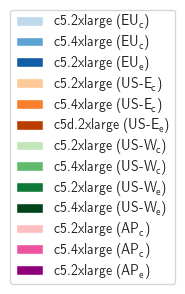

In [53]:
def plot_df_alloc(df_alloc, title, colors):
    """Receives a data frame. Each row is a time slot (identified by the column ts), followed
    by the number of VMs for each instance class (each one in column). There must be a color
    for each instance class."""
    assert len(list(df_alloc.columns)[1:]) == len(colors)
    
    ax = df_alloc.set_index("ts").plot(kind="bar", stacked=True, color=colors, legend=False, figsize=(4,2))
    # ax.set_title(title)
    ax.set_ylabel("VMs")
    ax.set_xlabel("Time slot (h)")
    #     ax.legend(bbox_to_anchor=(1.0, 1.0))
    plt.savefig(FIG_DIR/f"alloc_{title}.png", bbox_inches='tight', dpi=600)
    
    return ax

ic_list = list(df_allocs.columns)[2:] # The first elements are "ts" and "variant"
colors = []
index_eu = index_us_east = index_us_west = index_ap = 70
color_inc = 70
for ic in ic_list:
    if "-eu-" in ic:
        colors.append(cm.Blues(index_eu))
        index_eu += color_inc
    elif "-us-east-" in ic:
        colors.append(cm.Oranges(index_us_east))
        index_us_east += color_inc
    elif "-us-west-" in ic:
        colors.append(cm.Greens(index_us_west))
        index_us_west += color_inc
    elif "-ap-" in ic:
        colors.append(cm.RdPu(index_ap))
        index_ap += color_inc
    else:
        raise ValueError("Invalid region value")

def new_ic_names(x):
    if "-" not in x:
        return x

    vm_type = x.split("-")[0]
    orig_region = "-".join(x.split("-")[1:])
    new_region = region_2_shortcut[orig_region]
    return f"{vm_type} ({new_region})"
        

for variant in variants:
    df_variant = df_allocs[df_allocs.approach==variant].drop("approach", axis=1)
    
    # Use nicer names
    df_variant_fig = df_variant.rename(columns=lambda x: new_ic_names(x))
    ax = plot_df_alloc(df_variant_fig, variant, colors)

patches, labels = ax.get_legend_handles_labels()
f = plt.figure(figsize=(1,1))
ax_legend = f.add_subplot(111)
ax_legend.set_axis_off()  #turn off the axis
# ax.legend(reversed([mpatches.Rectangle((0, 0), 1, 1, fc=handle.get_color(),
#                                                   linewidth=handle.get_linewidth(),
#                                                   alpha=handle.get_alpha())
#                                for handle in patches]) , reversed(labels))
ax_legend.legend(*ax.get_legend_handles_labels(), loc='center')
plt.gcf().savefig(FIG_DIR / "legend.png", bbox_inches = 'tight',  dpi=600)

## Distribution of requests

In [34]:
def is_user_region(reg: Region) -> bool:
    return reg.name.endswith("-u")

def get_req_reg_distribution(sol: Solution) -> List[Tuple[str, str, int]]:
    """Receives an edarop Solution and returns a list of values with this
    format:

        reg_src reg_dst app requests
    """
    alloc = sol.alloc
    
    reqs = {}
    for reg_src in sol.problem.regions:
        if is_user_region(reg_src):
            reqs[reg_src] = {}
            for reg_dst in sol.problem.regions:
                reqs[reg_src][reg_dst] = 0
    
    for alloc_ts in alloc.time_slot_allocs:
        for key in alloc_ts.reqs:
            app = key[0]
            reg_src = key[1] 
            ic = key[2]
            reg_dst = ic.region
            
            reqs_ts = alloc_ts.reqs[key]
            reqs[reg_src][reg_dst] +=  reqs_ts
                
    res = []
    for reg_src in reqs.keys():
        for reg_dst in reqs[reg_src]:
            res.append((reg_src.name, reg_dst.name, app.name, reqs[reg_src][reg_dst]))
                
    return res

req_dist = []
for ts, sols_ts in enumerate(all_sols):
    for i, variant in enumerate(variants):
        sol = sols_ts[i]
        for distribution in get_req_reg_distribution(sol):
            req_dist.append((ts, variant, *distribution))

df_reg_dist = pd.DataFrame(req_dist, columns=["Time slot (h)", "Approach", "Reg_src", "Reg_dst", "App", "Requests"])
df_reg_dist.Reg_src = df_reg_dist.Reg_src.map(region_2_shortcut)
df_reg_dist.Reg_dst = df_reg_dist.Reg_dst.map(region_2_shortcut)

reg_dst_order_reversed = reg_dst_order.copy()
reg_dst_order_reversed.reverse()

df_reg_dist.Reg_src = df_reg_dist.Reg_src.astype("category").cat.set_categories(reg_src_order)
df_reg_dist.Reg_dst = df_reg_dist.Reg_dst.astype("category").cat.set_categories(reg_dst_order_reversed)

df_reg_dist = df_reg_dist.sort_values(by=["Reg_src", "Reg_dst"])

In [35]:
df_reg_dist_gr = (df_reg_dist
     .groupby(["Approach", "Reg_src", "Reg_dst"])
     .Requests
     .sum()
     .reset_index()
)

In [36]:
import plotly.graph_objects as go
import kaleido

In [51]:
def clean_label(label):
    clean = label.replace("$", "").replace("{", "").replace("}", "").replace(r"\text", "")
    return clean.replace("_", "<sub>") + "</sub>"

In [58]:
def hex_to_rgb(x):
    x = x[1:]
    return tuple(int(x[i:i+2], 16) for i in (0, 2, 4))

df_s = df_reg_dist_gr[df_reg_dist_gr.Approach=="EdaropC"]
def plot_dist_sankey(df: pd.DataFrame, title: str):
    """Recevies a region distribution DataFrame like this:
    
       Variant Reg_src Reg_dst      Requests
    0  EdaropC       H       M  2.250685e+07
    1  EdaropC       H       O  2.358489e+07
    2  EdaropC       H      NV  2.323511e+08
    3  EdaropC       H       F -1.862645e-09
    4  EdaropC       H       D  0.000000e+00
    
    And plots a Sankey plot of how the requests are distributed
    """
    regs_src = df.Reg_src.unique()
    num_src_regs = len(regs_src)
    
    regs_dst = list(df.Reg_dst.unique())
    regs_dst.reverse()
    
    label = [*regs_src, *regs_dst]
    label = [clean_label(l) for l in label]

    source = []
    target = []
    value = []
    for rs_i, rs in enumerate(regs_src):
        for rd_i, rd in enumerate(regs_dst):
            source.append(rs_i)
            target.append(num_src_regs+rd_i)
            value.append(int(df.query(f"Reg_src == r'{rs}' and Reg_dst == r'{rd}'").Requests))

    secondary_colors = tuple(cm.tab20.colors[x] for x in range(1,num_src_regs*2+1,2))
    node_rgb_color = cm.tab10.colors[:num_src_regs] + cm.tab10.colors[:num_src_regs] + secondary_colors
    node_color = [matplotlib.colors.rgb2hex(c) for c in node_rgb_color]
    link_color = node_color.copy()*num_src_regs

    link_color = ['rgba({},{},{}, 0.4)'.format(
        hex_to_rgb(x)[0],
        hex_to_rgb(x)[1],
        hex_to_rgb(x)[2]) for x in link_color]

    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = label,
          color = node_color,
        ),
        link = dict(
          source = source,
          target = target,
          value = value,
          color = link_color,
      ))])

    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        font=dict(
            family="Arial",
            size=22,
            color="Black"
            )
    )
    fig.show()
    fig.write_image(FIG_DIR / f"dist_{title}.png", scale=2)
    
for v in variants:
    plot_dist_sankey(df_reg_dist_gr[df_reg_dist_gr.Approach==v], title=v)

## Creation and solving times

In [62]:
stats = []
for ts, sols_ts in enumerate(all_sols):
    sols = {}
    for i, variant in enumerate(variants):
        sol = sols_ts[i]
        creation_time = sol.solving_stats.creation_time
        solving_time = sol.solving_stats.solving_time
        stats.append((ts, variant, "Creation", creation_time))
        stats.append((ts, variant, "Solving", solving_time))
    
df_stats = pd.DataFrame(stats, columns=["Time slot (h)", "Approach", "Type", "Time (s)"])

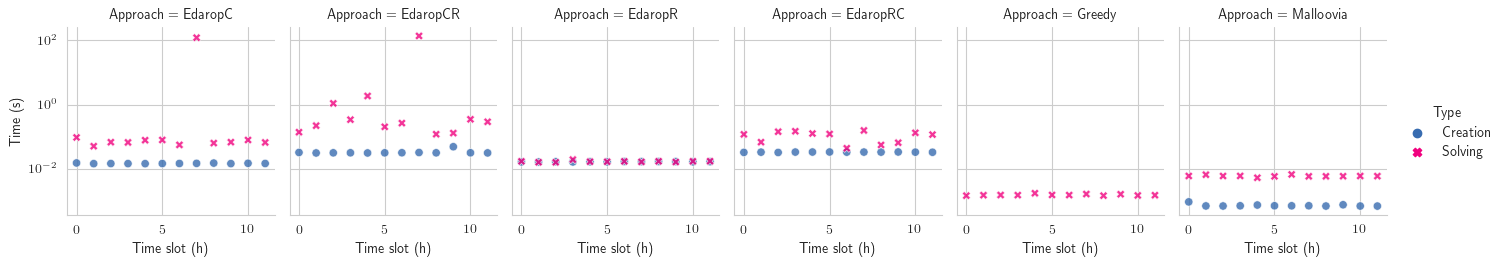

In [63]:
# Use the Accent pallete but not from the first color to differenciate
# it from the colors of the Accent pallete used for destination before
stats_palette = [plt.cm.Accent(i+4) for i in range(2)]

g = sns.relplot(data=df_stats, x="Time slot (h)", y="Time (s)",
           hue="Type", col="Approach", style="Type",
           height=2.75, aspect=0.85, palette=stats_palette, alpha=0.8)
plt.yscale('log')
plt.savefig(FIG_DIR/'stats.png', bbox_inches='tight', dpi=600)

### Separated in two rows

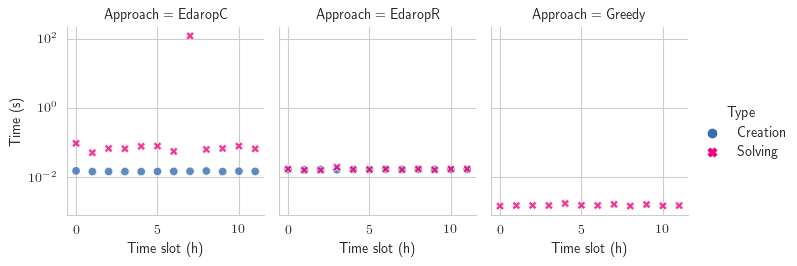

In [67]:
stats_palette = [plt.cm.Accent(i+4) for i in range(2)]

g = sns.relplot(data=df_stats[df_stats.Approach.isin(["EdaropC", "EdaropR", "Greedy"])], x="Time slot (h)", y="Time (s)",
           hue="Type", col="Approach", style="Type",
           height=2.75, aspect=0.85, palette=stats_palette, alpha=0.8)
plt.yscale('log')
plt.savefig(FIG_DIR/'stats1.png', bbox_inches='tight', dpi=600)

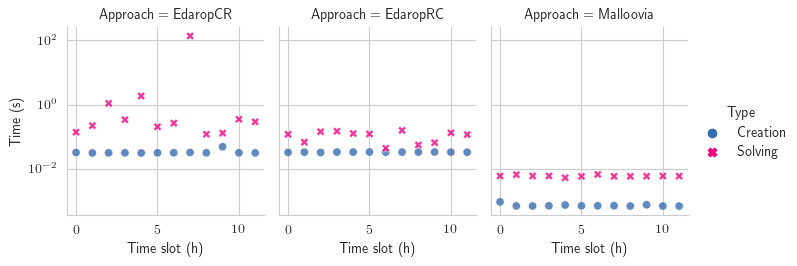

In [70]:
stats_palette = [plt.cm.Accent(i+4) for i in range(2)]

g = sns.relplot(data=df_stats[~df_stats.Approach.isin(["EdaropC", "EdaropR", "Greedy"])], x="Time slot (h)", y="Time (s)",
           hue="Type", col="Approach", style="Type",
           height=2.75, aspect=0.85, palette=stats_palette, alpha=0.8)
plt.yscale('log')
plt.savefig(FIG_DIR/'stats2.png', bbox_inches='tight', dpi=600)